<h1> Test Mauro</h1> 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
from astropy.cosmology import FlatLambdaCDM
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

# Flag needed to simulate the standard LIGO SOBBH population

SOBBH = False
SOBBH_Redevol = False
SOBBH_RSpike = False

# Flags for different types of PBH mass distribution

PBH = False
PBH_fRz = False
PBH_fRt = False
PBH_LogNormal = False
PBH_Gaussian = False

# Merger distribution parameters

T_obs = 6. # Lisa estimated years of observation
efficiency = 0.75 # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
MPc = 3.08567758149137*1e22 # meters
GPc = MPc*1e3 # meters
h = 0.6736
H_0 = 67.36#*1.e3/MPc # Hubble constant in 1/(s)
Omega_m = 0.3158 # Matter density in our universe
Omega_k = 0. # Curvature density in our universe
Omega_lambda = 1. - Omega_m - Omega_k # Cosmological constant density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 10
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1


In [3]:
%run BigFont.py

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [4]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_max = 1.e5
z_prec = 1000

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)))
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    Int_Z = 0.
    span_z = np.logspace(np.log10(z),np.log10(z_max),z_prec)
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    for i in range(len(span_z) -1):
        mid_z = 0.5*(span_z[i] + span_z[i + 1])
        Int_Z += (span_z[i + 1] -  span_z[i])/(H(mid_z)*(1. + mid_z))
    
    return Int_Z
    
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail        

<h3> SOBBH - Number density of events</h3>

We may finally define the distribution function for the number of events,in particular let's start with the function that describes the merging rate dependancy on the reference frame time: 

In [5]:
def DtrDz(z):
    ris = 1./(H_0*(1. + z)*np.sqrt(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))
    return ris
        

<h2> Merging Rates Test </h2>

In [6]:
#Mauro R(z)

SOBBH_k = 2.9
SOBBH_CorrRz = lambda z : (1. +z)**SOBBH_k /(1  +((1 + z)/2.9)**(SOBBH_k +2.9))
SOBBH_R = lambda z : 28.3*SOBBH_CorrRz(z)/SOBBH_CorrRz(0.) 

# Min R(z)

#SOBBH_k = 2.7 # + 1.8 - 1.9  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
#SOBBH_CorrRz = (((1. + 0.2)**SOBBH_k)/(1. + ((1. + 0.2)/2.9)**(SOBBH_k + 2.9)))**(-1) # Normalization factor estimated at z = 0.2
SOBBH_Redevol = True

# Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

#SOBBH_R0 = {}
#SOBBH_R0[0] = 28.1 # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted at z = 0.2
#SOBBH_R0[1] = 23.9 # +14.9 - 8.6 m^-3 s^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

#def SOBBH_R(z):
#    if(SOBBH_Redevol):
#        # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
#        return SOBBH_R0[0]*SOBBH_CorrRz*((1. + z)**SOBBH_k)/(1. + ((1. + z)/2.9)**(SOBBH_k + 2.9))
#    else:
#        return SOBBH_R0[1]

In [7]:
def PBH_fRt(z,f):
        return f*PBH_R0*PBH_CorrfRz*((t_z(z)/t_0)**(-34./37.))

In [8]:
PBH_R0 = 28.3 # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
PBH_CorrfRz = 1./(1. + 0.2)**2.9 # normalization factor needed to express the value of the LIGO merging rate in z=0
    
def PBH_fRz(z,f):
    if(z <= 1.):
        PBH_k = 1.1 # Value taken from arxiv 2201.12218, valid for small z !!
        return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k)
    else:
        PBH_k = 1.4 # Value taken from arxiv 2201.12218, valid for high z !!
        PBH_R1_corr = f*PBH_R0*PBH_CorrfRz*(((2.)**PBH_k) - ((2.)**1.1))
        return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k) - PBH_R1_corr

In [9]:
ran_z = np.linspace(0.,10.,2500)
ran_mz = np.linspace(0.,10.,2500 - 1)
ran_mz = 0.5*(ran_z[:len(ran_z) -1:] + ran_z[1::])

In [10]:
t_span = Z_to_HubbleTime(ran_mz)
Dc_span = Z_to_Gpc(ran_mz)
t_z = interpolate.interp1d(ran_mz, t_span)
Dc_z = interpolate.interp1d(ran_mz, Dc_span)

In [11]:
%run BigFont.py

In [12]:
PBH_Rz = np.linspace(0.,10.,2500 - 1)

for i in range(len(ran_mz)):
    PBH_Rz[i] = PBH_fRz(ran_mz[i],1.)

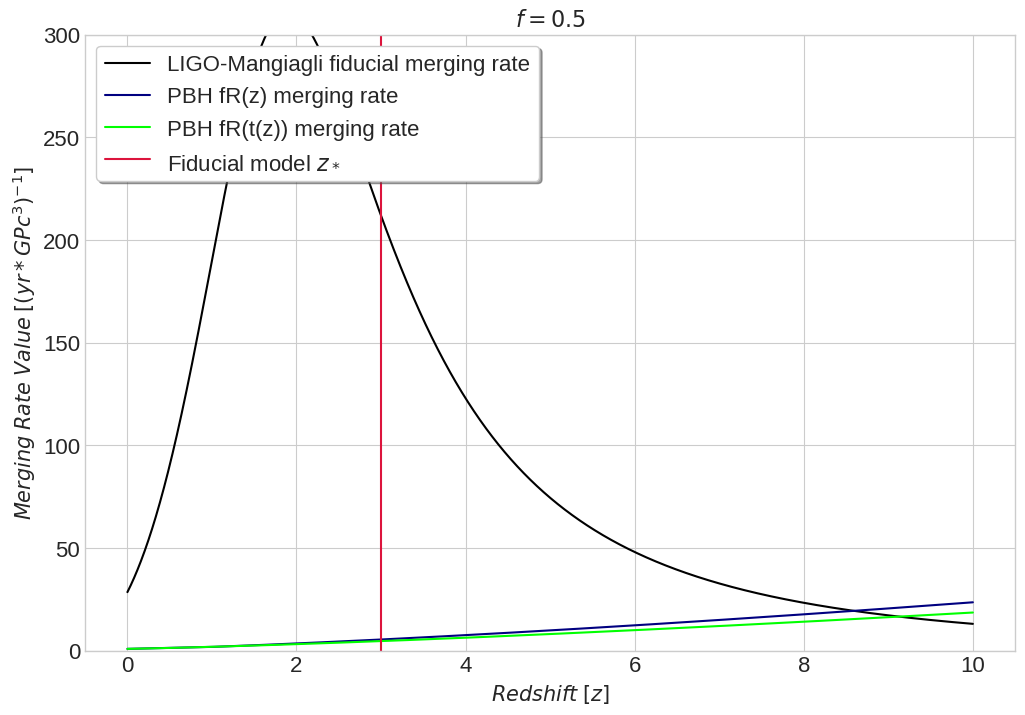

In [13]:
plt.figure(figsize=(12,8))
plt.plot(ran_mz, SOBBH_R(ran_mz), color = 'black', label = 'LIGO-Mangiagli fiducial merging rate')
plt.plot(ran_mz, 0.05*PBH_Rz, color = 'navy', label = 'PBH fR(z) merging rate')
plt.plot(ran_mz, 0.05*PBH_fRt(ran_mz, 1.), color = 'lime', label = 'PBH fR(t(z)) merging rate')
plt.axvline(3., color = 'crimson', label = 'Fiducial model $z_*$')
plt.xlabel('$Redshift \; [z]$', fontsize = 15 )
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True)
plt.ylabel('$Merging \; Rate \; Value \; [(yr*GPc^{3})^{-1}]$', fontsize = 15)
plt.ylim(0.,300)
plt.title(r'$f = 0.5$')
plt.savefig('AllMergingRatesTimesMauroFacf50.png',dpi=500)


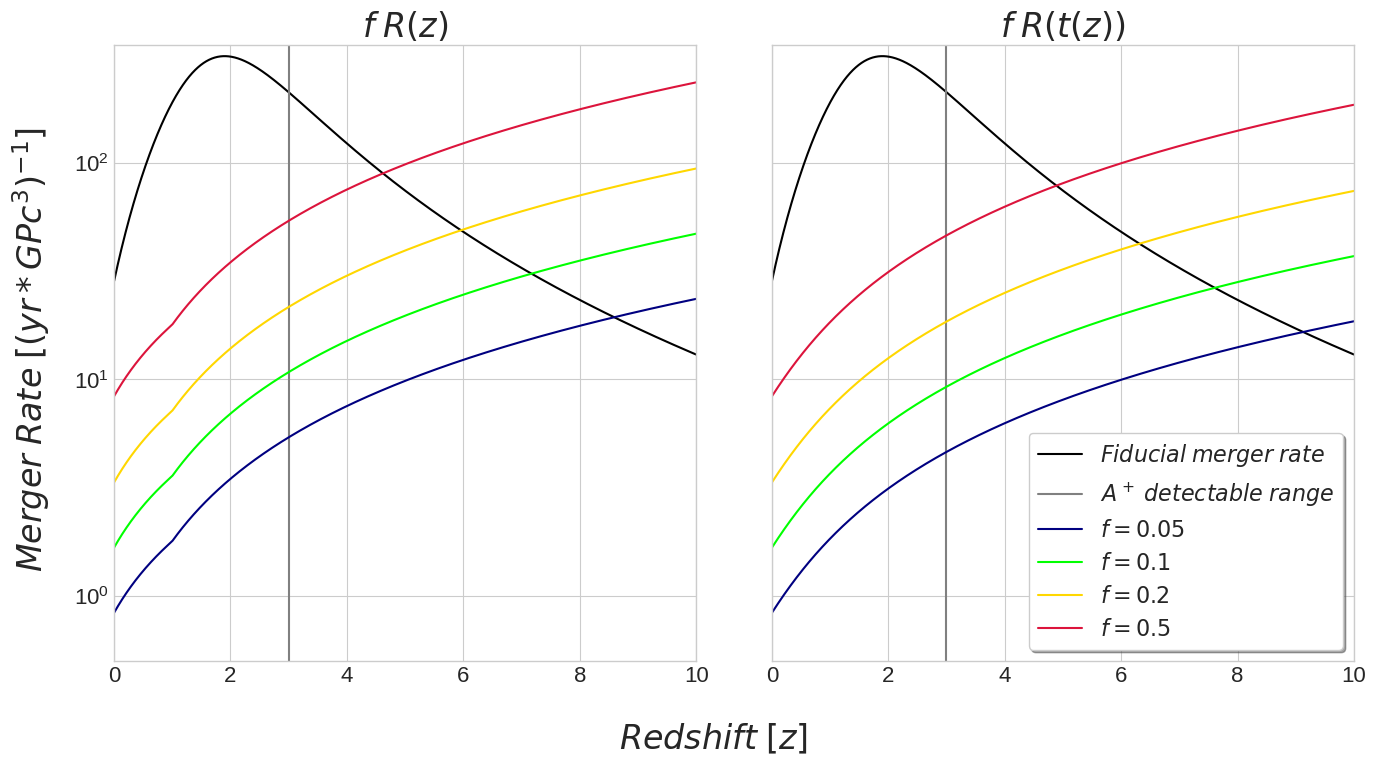

In [14]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize =[16,8])
plt.subplots_adjust(wspace = 0.13, hspace = 0.5)
fig.text(0.06, 0.5, '$Merger \; Rate  \; [(yr*GPc^{3})^{-1}]$', fontsize = 24, va = 'center', rotation='vertical')
fig.text(0.5, 0.0, '$Redshift \; [z]$', fontsize = 24, ha = 'center')
    
ax[0].set_title(r'$f \;R(z)$', fontsize = 24)
ax[1].set_title(r'$f \; R(t(z))$', fontsize = 24)

ax[0].plot(ran_mz, SOBBH_R(ran_mz), color = 'black', label = r'$Fiducial \; merger \; rate$')
ax[0].axvline(3., color = 'gray', label = r'$A^+ \; detectable \; range$')
ax[0].plot(ran_mz, 0.05*PBH_Rz, color = 'navy', label = r'$f = 0.05$')
ax[0].plot(ran_mz, 0.1*PBH_Rz, color = 'lime', label = r'$f = 0.1$')
ax[0].plot(ran_mz, 0.2*PBH_Rz, color = 'gold', label = r'$f = 0.2$')
ax[0].plot(ran_mz, 0.5*PBH_Rz, color = 'crimson', label = r'$f = 0.5$')


ax[1].plot(ran_mz, SOBBH_R(ran_mz), color = 'black', label = r'$Fiducial \; merger \; rate$')
ax[1].axvline(3., color = 'gray', label = r'$A^+ \; detectable \; range$')
ax[1].plot(ran_mz, 0.05*PBH_fRt(ran_mz, 1.), color = 'navy', label = r'$f = 0.05$')
ax[1].plot(ran_mz, 0.1*PBH_fRt(ran_mz, 1.), color = 'lime', label = r'$f = 0.1$')
ax[1].plot(ran_mz, 0.2*PBH_fRt(ran_mz, 1.), color = 'gold', label = r'$f = 0.2$')
ax[1].plot(ran_mz, 0.5*PBH_fRt(ran_mz, 1.), color = 'crimson', label = r'$f = 0.5$')


ax[0].set_xlim(0.,10.)
ax[0].set_ylim(0.5,350.)
ax[0].set_yscale('log')

ax[1].set_xlim(0.,10.)
ax[1].set_ylim(0.5,350.)
ax[1].set_yscale('log')
ax[1].legend(loc=4, frameon = True, fancybox = True, shadow = True)  

plt.savefig('MergingRateComparison.png', dpi = 200)
#plt.savefig('MergingRateComparison.png', dpi = 50)

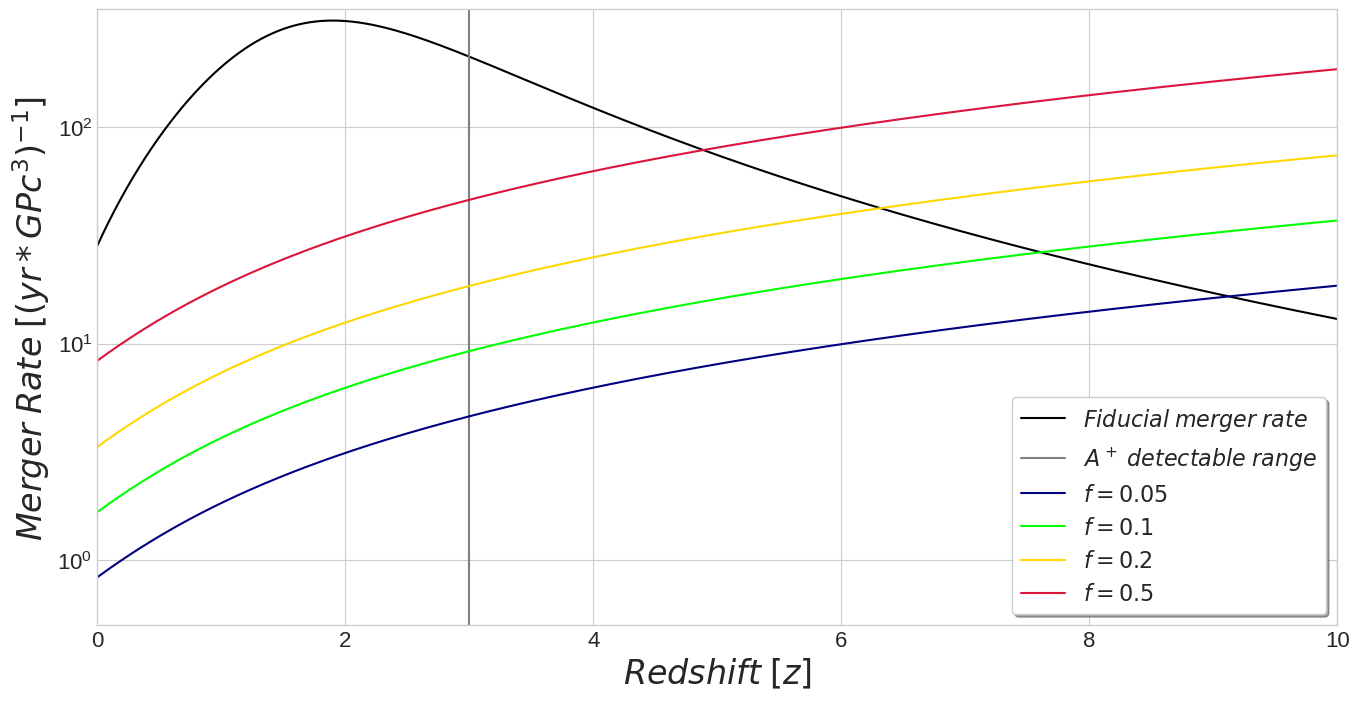

In [20]:
plt.figure(figsize=(16,8))
plt.ylabel('$Merger \; Rate  \; [(yr*GPc^{3})^{-1}]$', fontsize = 24)
plt.xlabel('$Redshift \; [z]$', fontsize = 24, ha = 'center')


plt.plot(ran_mz, SOBBH_R(ran_mz), color = 'black', label = r'$Fiducial \; merger \; rate$')
plt.axvline(3., color = 'gray', label = r'$A^+ \; detectable \; range$')
plt.plot(ran_mz, 0.05*PBH_fRt(ran_mz, 1.), color = 'navy', label = r'$f = 0.05$')
plt.plot(ran_mz, 0.1*PBH_fRt(ran_mz, 1.), color = 'lime', label = r'$f = 0.1$')
plt.plot(ran_mz, 0.2*PBH_fRt(ran_mz, 1.), color = 'gold', label = r'$f = 0.2$')
plt.plot(ran_mz, 0.5*PBH_fRt(ran_mz, 1.), color = 'crimson', label = r'$f = 0.5$')



plt.xlim(0.,10.)
plt.ylim(0.5,350.)
plt.yscale('log')
plt.legend(loc=4, frameon = True, fancybox = True, shadow = True)  

plt.savefig('RtzMergingRateComparison.png', dpi = 200)
#plt.savefig('RtzMergingRateComparison.png', dpi = 50)